In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, lower, regexp_replace, log1p, trim
from pyspark.sql.types import DoubleType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [4]:
# --- 1. PYSPARK SETUP AND DATA INGESTION ---
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("AmazonBestsellersEDA") \
    .getOrCreate()

In [5]:
# Function to get the file path from the user
def get_file_path():
    """Prompts the user for the CSV file path and validates it."""
    # NOTE: I am setting your specific path as the default value here.
    default_path = r"C:\Users\THARUN\OneDrive\Documents\Amazon_bestsellers_items_2025.csv"
    
    while True:
        print(f"Default file path: {default_path}")
        file_path_input = input("Please confirm or enter the FULL, local path to your Amazon_bestsellers_items_2025.csv file (Press Enter to use default): ")
        
        # Use default path if the user just presses Enter
        file_path = file_path_input if file_path_input else default_path
        
        # Simple validation: check if the file exists locally
        if os.path.exists(file_path):
            return file_path
        else:
            print(f"Error: File not found at '{file_path}'. Please check the path and try again.")

In [6]:
# Get the file path
csv_file_path = get_file_path()
print(f"Loading data from: {csv_file_path}")

Default file path: C:\Users\THARUN\OneDrive\Documents\Amazon_bestsellers_items_2025.csv


Please confirm or enter the FULL, local path to your Amazon_bestsellers_items_2025.csv file (Press Enter to use default):  C:\Users\THARUN\OneDrive\Documents\Amazon_bestsellers_items_2025.csv


Loading data from: C:\Users\THARUN\OneDrive\Documents\Amazon_bestsellers_items_2025.csv


In [7]:
# Load the actual dataset using the provided path
print("--- 1. Loading Data ---")
# InferSchema is set to True to automatically detect column types
try:
    df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
except Exception as e:
    print(f"Failed to load data. PySpark Error: {e}")
    spark.stop()
    exit()

--- 1. Loading Data ---


In [8]:
# --- 2. SUMMARIZE THE DATA SET ---
print("\n" + "="*50)
print("--- 2. INITIAL DATA SUMMARY ---")
print("="*50)


--- 2. INITIAL DATA SUMMARY ---


In [9]:
# A. Print Schema
print("\nSchema:")
df.printSchema()


Schema:
root
 |-- _c0: integer (nullable = true)
 |-- rank: integer (nullable = true)
 |-- asin: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_price: string (nullable = true)
 |-- product_star_rating: double (nullable = true)
 |-- product_num_ratings: double (nullable = true)
 |-- product_url: string (nullable = true)
 |-- product_photo: string (nullable = true)
 |-- rank_change_label: string (nullable = true)
 |-- country: string (nullable = true)
 |-- page: integer (nullable = true)



In [10]:
# B. Show Sample Data
print("\nSample Data:")
df.show(5, truncate=False)


Sample Data:
+---+----+----------+-----------------------------------------------------------------------------------------------------------------------------+-------------+-------------------+-------------------+-----------------------------------+-------------------------------------------------------------------------------------+-----------------+-------+----+
|_c0|rank|asin      |product_title                                                                                                                |product_price|product_star_rating|product_num_ratings|product_url                        |product_photo                                                                        |rank_change_label|country|page|
+---+----+----------+-----------------------------------------------------------------------------------------------------------------------------+-------------+-------------------+-------------------+-----------------------------------+---------------------------------------

In [11]:
# C. Descriptive Statistics for Numerical Columns
print("\nDescriptive Statistics (Numerical Columns):")
df.select("rank", "product_star_rating", "product_num_ratings").describe().show()


Descriptive Statistics (Numerical Columns):
+-------+------------------+-------------------+-------------------+
|summary|              rank|product_star_rating|product_num_ratings|
+-------+------------------+-------------------+-------------------+
|  count|               999|                969|                969|
|   mean|50.450450450450454|  4.140247678018574|  1312.546955624355|
| stddev|28.852421419020956|0.49638188918869774| 3025.2415374018315|
|    min|                 1|                1.0|                1.0|
|    max|               100|                5.0|            19189.0|
+-------+------------------+-------------------+-------------------+



In [12]:
# D. Null Value Check (Crucial step for cleaning)
print("\nNull Value Counts:")
df.agg(*[(count(when(col(c).isNull(), c)).alias(c)) for c in df.columns]).show()


Null Value Counts:
+---+----+----+-------------+-------------+-------------------+-------------------+-----------+-------------+-----------------+-------+----+
|_c0|rank|asin|product_title|product_price|product_star_rating|product_num_ratings|product_url|product_photo|rank_change_label|country|page|
+---+----+----+-------------+-------------+-------------------+-------------------+-----------+-------------+-----------------+-------+----+
|  0|   0|   0|            0|           54|                 30|                 30|          0|            0|              999|      0|   0|
+---+----+----+-------------+-------------+-------------------+-------------------+-----------+-------------+-----------------+-------+----+



In [13]:
# E. Cardinality Check (for categorical columns)
print("\nCardinality Check:")
for c in ["country", "rank_change_label"]:
    print(f"Column '{c}' has {df.select(c).distinct().count()} distinct values.")


Cardinality Check:
Column 'country' has 10 distinct values.
Column 'rank_change_label' has 1 distinct values.


In [14]:
# --- 3. DATA CLEANING ---
print("\n" + "="*50)
print("--- 3. DATA CLEANING & TRANSFORMATION ---")
print("="*50)


--- 3. DATA CLEANING & TRANSFORMATION ---


In [15]:
# 3.1 Drop unnecessary index column (_c0 is the first unnamed column)
# Rename the column with the rank for consistency
df_cleaned = df.drop("_c0").withColumnRenamed("rank", "product_rank")
print("Dropped index column '_c0' and renamed 'rank' to 'product_rank'.")

Dropped index column '_c0' and renamed 'rank' to 'product_rank'.


In [16]:
# 3.2 Clean and Convert 'product_price'
# Remove all currency symbols ($, ₹, €, ￥), commas, and all forms of whitespace, then convert to Double.
df_cleaned = df_cleaned.withColumn("product_price",
    regexp_replace(trim(col("product_price")), "[$,₹,€,￥\\s\u00a0]", "").cast(DoubleType())
)

In [17]:
# Drop rows where 'product_price' is null after casting (critical for analysis)
initial_count = df.count()
df_cleaned = df_cleaned.dropna(subset=["product_price"])
print(f"Dropped {initial_count - df_cleaned.count()} rows with null/unparseable 'product_price'.")

Dropped 54 rows with null/unparseable 'product_price'.


In [18]:
# 3.3 Handle Nulls in 'product_star_rating' (Imputation with Mean)
# Calculate mean on the current cleaned set to ensure accuracy
mean_rating = df_cleaned.select(mean(col("product_star_rating"))).collect()[0][0] or 0
df_cleaned = df_cleaned.withColumn("product_star_rating",
    when(col("product_star_rating").isNull(), mean_rating).otherwise(col("product_star_rating")).cast(DoubleType())
)
print(f"Imputed 'product_star_rating' missing values with the mean: {mean_rating:.2f}")

Imputed 'product_star_rating' missing values with the mean: 4.14


In [19]:
# 3.4 Handle Nulls in 'product_num_ratings' (Imputation with 0, assuming no entry means no ratings)
df_cleaned = df_cleaned.withColumn("product_num_ratings",
    when(col("product_num_ratings").isNull(), 0).otherwise(col("product_num_ratings")).cast(IntegerType())
)
print("Imputed 'product_num_ratings' missing values with 0.")

Imputed 'product_num_ratings' missing values with 0.


In [20]:
# 3.5 Standardize 'country'
df_cleaned = df_cleaned.withColumn("country", lower(col("country")))
print("Standardized 'country' (lowercase).")

Standardized 'country' (lowercase).


In [21]:
# 3.6 Log transformation for skewed data (Product Num Ratings) to use in plots
df_cleaned = df_cleaned.withColumn("log_num_ratings", log1p(col("product_num_ratings")))
print("Created 'log_num_ratings' for better visualization of skewed data.")

print("\nCleaned Data Sample:")
df_cleaned.show(5, truncate=False)
print(f"Final record count: {df_cleaned.count()}")

Created 'log_num_ratings' for better visualization of skewed data.

Cleaned Data Sample:
+------------+----------+-----------------------------------------------------------------------------------------------------------------------------+-------------+-------------------+-------------------+-----------------------------------+-------------------------------------------------------------------------------------+-----------------+-------+----+-----------------+
|product_rank|asin      |product_title                                                                                                                |product_price|product_star_rating|product_num_ratings|product_url                        |product_photo                                                                        |rank_change_label|country|page|log_num_ratings  |
+------------+----------+-----------------------------------------------------------------------------------------------------------------------------+------

In [26]:
# --- 4. DATA VISUALIZATION (10 GRAPHS) ---

# Collect the necessary data to a Pandas DataFrame for plotting
print("\n" + "="*50)
print("--- 4. GENERATING 10 VISUALIZATIONS ---")
print("="*50)


--- 4. GENERATING 10 VISUALIZATIONS ---


In [27]:
# Check if the dataframe is empty after cleaning
if df_cleaned.count() == 0:
    print("Error: No data records remaining after cleaning. Cannot generate plots.")
    spark.stop()
    exit()

pdf = df_cleaned.toPandas()

plt.style.use('seaborn-v0_8-darkgrid')
print("Note: 10 individual plot windows will be generated sequentially.")

Note: 10 individual plot windows will be generated sequentially.


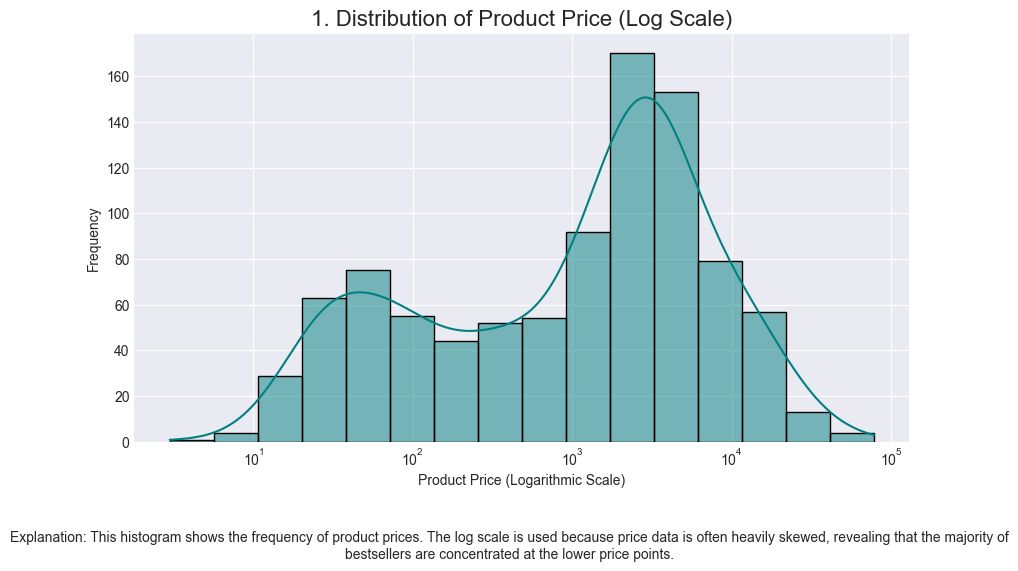

In [28]:
# ----------------------------------------------------------------------
# PLOT 1: Distribution of Product Price (Histogram, Log-Scaled Price)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(pdf['product_price'], kde=True, color='teal', log_scale=True)
plt.title('1. Distribution of Product Price (Log Scale)', fontsize=16)
plt.xlabel('Product Price (Logarithmic Scale)')
plt.ylabel('Frequency')
plt.figtext(0.5, 0.01, 
    'Explanation: This histogram shows the frequency of product prices. The log scale is used because price data is often heavily skewed, revealing that the majority of bestsellers are concentrated at the lower price points.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

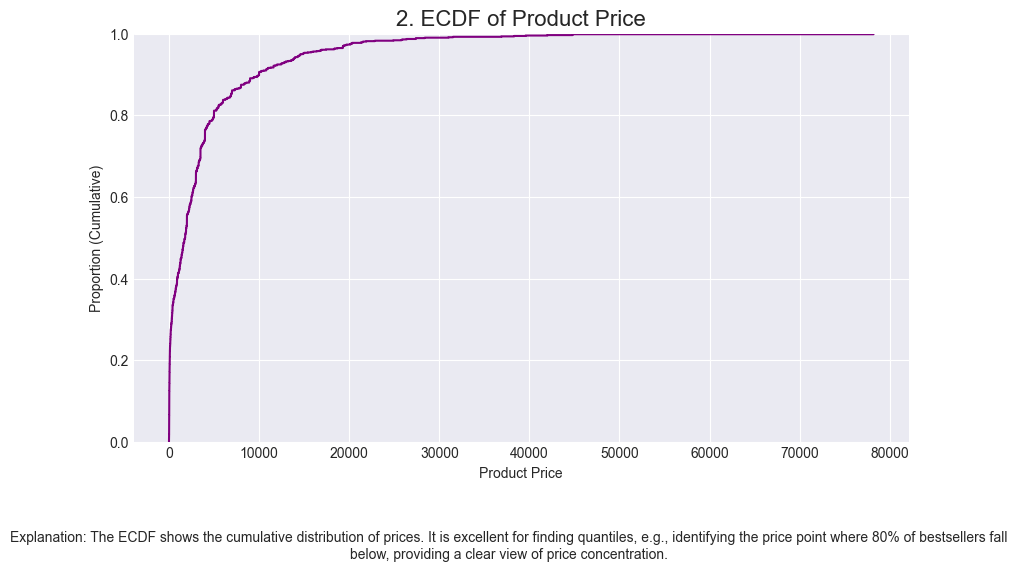

In [29]:
# ----------------------------------------------------------------------
# PLOT 2: ECDF (Empirical Cumulative Distribution Function) of Product Price
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=pdf, x='product_price', color='purple')
plt.title('2. ECDF of Product Price', fontsize=16)
plt.xlabel('Product Price')
plt.ylabel('Proportion (Cumulative)')
plt.figtext(0.5, 0.01, 
    'Explanation: The ECDF shows the cumulative distribution of prices. It is excellent for finding quantiles, e.g., identifying the price point where 80% of bestsellers fall below, providing a clear view of price concentration.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

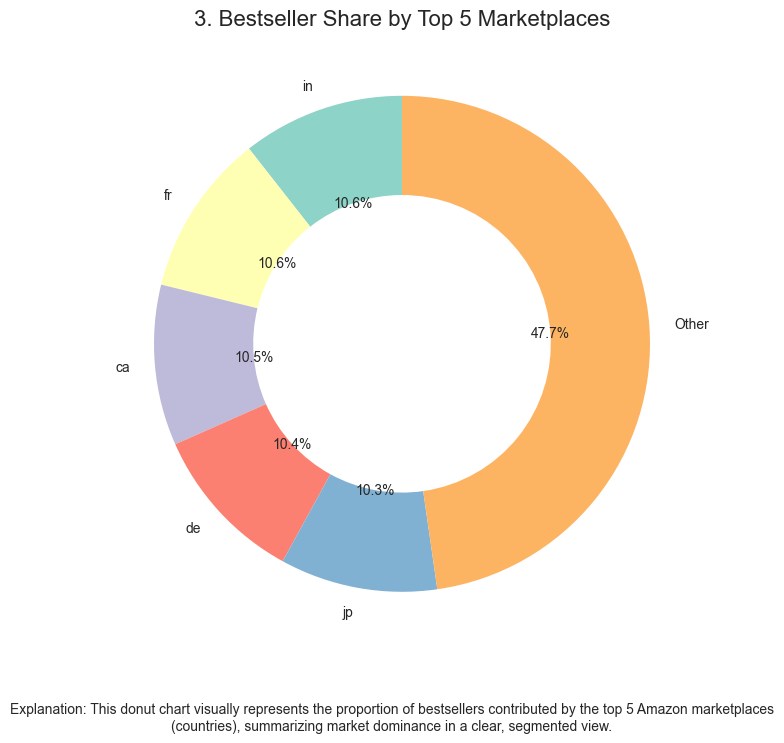

In [30]:
# ----------------------------------------------------------------------
# PLOT 3: Donut Chart of Bestseller Share by Country
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 8))
country_counts = pdf['country'].value_counts().head(5)
other_count = pdf['country'].count() - country_counts.sum()

# Use pd.concat for modern Pandas compatibility
country_data = pd.concat([
    country_counts, 
    pd.Series({'Other': other_count}, name='country')
])

plt.pie(country_data.values, labels=country_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors, wedgeprops=dict(width=0.4))
plt.title('3. Bestseller Share by Top 5 Marketplaces', fontsize=16)
plt.figtext(0.5, 0.01, 
    'Explanation: This donut chart visually represents the proportion of bestsellers contributed by the top 5 Amazon marketplaces (countries), summarizing market dominance in a clear, segmented view.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.1)
plt.show()

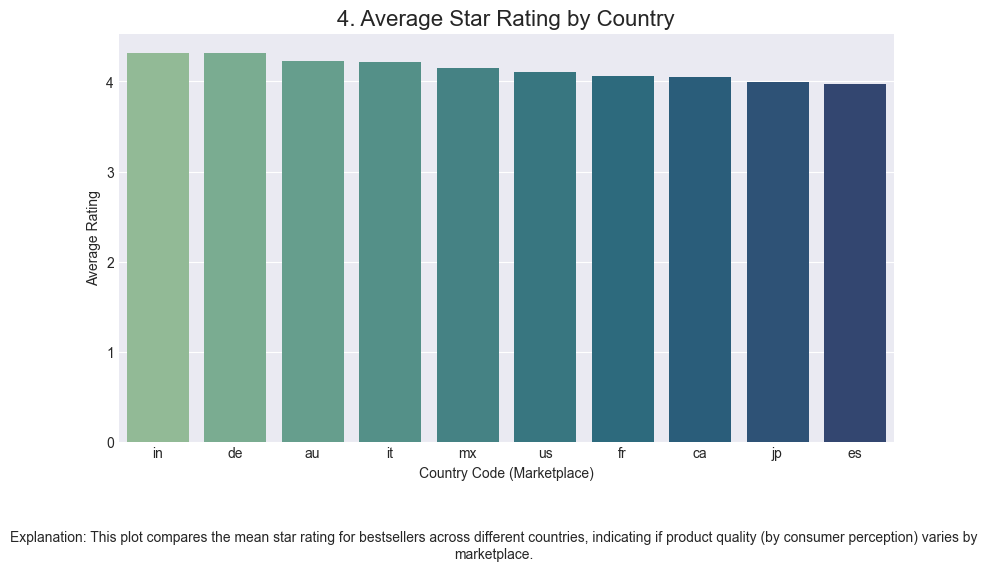

In [31]:
# ----------------------------------------------------------------------
# PLOT 4: Average Star Rating by Country (Bar Plot)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
country_rating = pdf.groupby('country')['product_star_rating'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='country', y='product_star_rating', data=country_rating, palette='crest', 
            hue='country', legend=False)
plt.title('4. Average Star Rating by Country', fontsize=16)
plt.xlabel('Country Code (Marketplace)')
plt.ylabel('Average Rating')
plt.figtext(0.5, 0.01, 
    'Explanation: This plot compares the mean star rating for bestsellers across different countries, indicating if product quality (by consumer perception) varies by marketplace.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

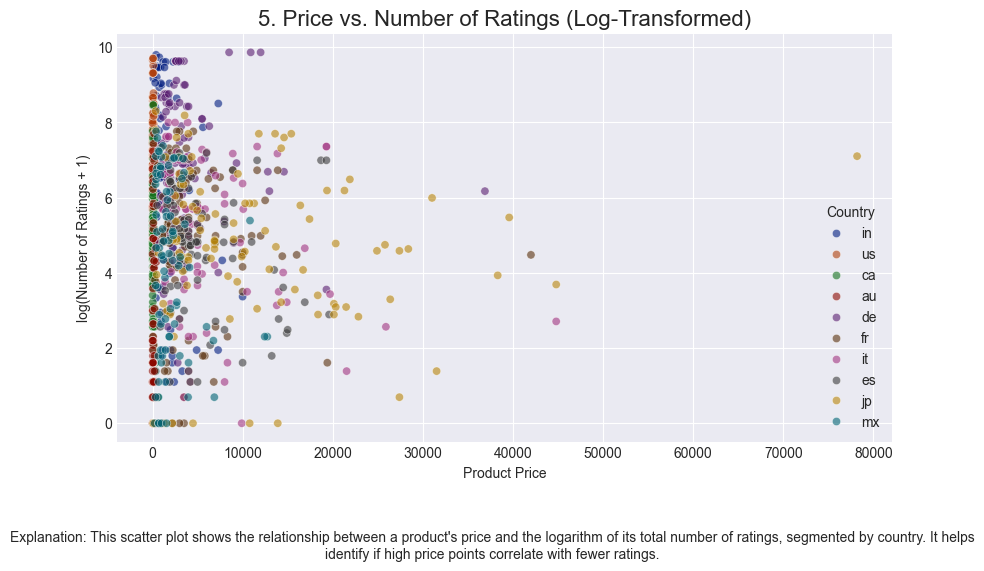

In [32]:
# ----------------------------------------------------------------------
# PLOT 5: Price vs. Log of Number of Ratings (Scatter Plot)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='product_price', y='log_num_ratings', data=pdf, hue='country', palette='dark', alpha=0.6)
plt.title('5. Price vs. Number of Ratings (Log-Transformed)', fontsize=16)
plt.xlabel('Product Price')
plt.ylabel('log(Number of Ratings + 1)')
plt.legend(title='Country')
plt.figtext(0.5, 0.01, 
    'Explanation: This scatter plot shows the relationship between a product\'s price and the logarithm of its total number of ratings, segmented by country. It helps identify if high price points correlate with fewer ratings.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

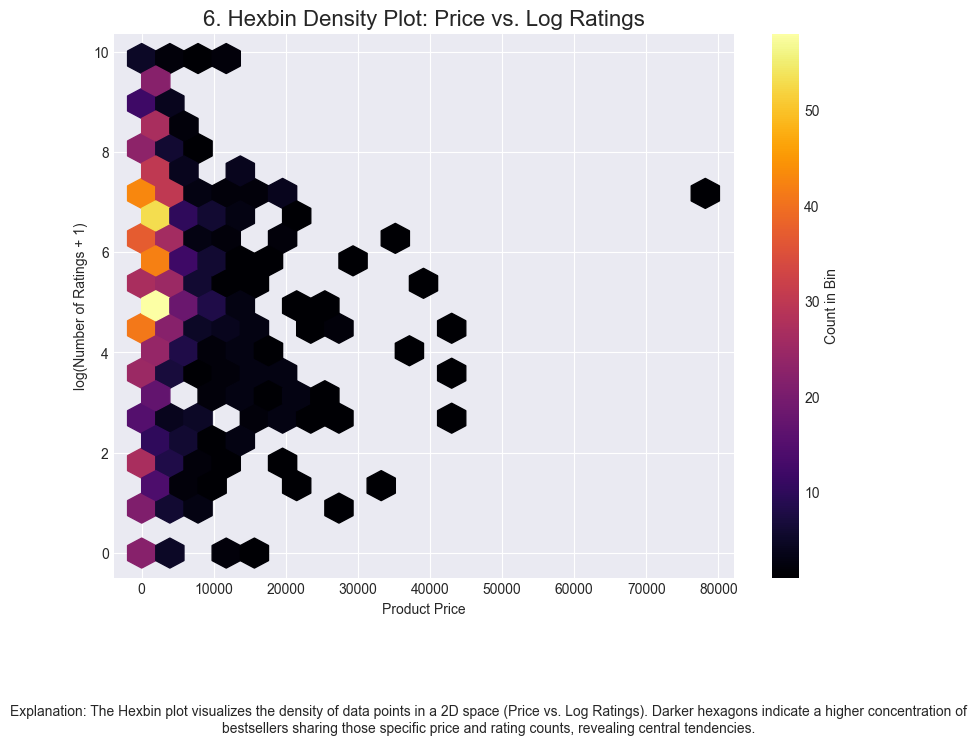

In [33]:
# ----------------------------------------------------------------------
# PLOT 6: Hexbin Plot for Price vs. Log Ratings Density
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 8))
hb = plt.hexbin(pdf['product_price'], pdf['log_num_ratings'], gridsize=20, cmap='inferno', mincnt=1)
plt.title('6. Hexbin Density Plot: Price vs. Log Ratings', fontsize=16)
plt.xlabel('Product Price')
plt.ylabel('log(Number of Ratings + 1)')
plt.colorbar(hb, label='Count in Bin')
plt.figtext(0.5, 0.01, 
    'Explanation: The Hexbin plot visualizes the density of data points in a 2D space (Price vs. Log Ratings). Darker hexagons indicate a higher concentration of bestsellers sharing those specific price and rating counts, revealing central tendencies.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

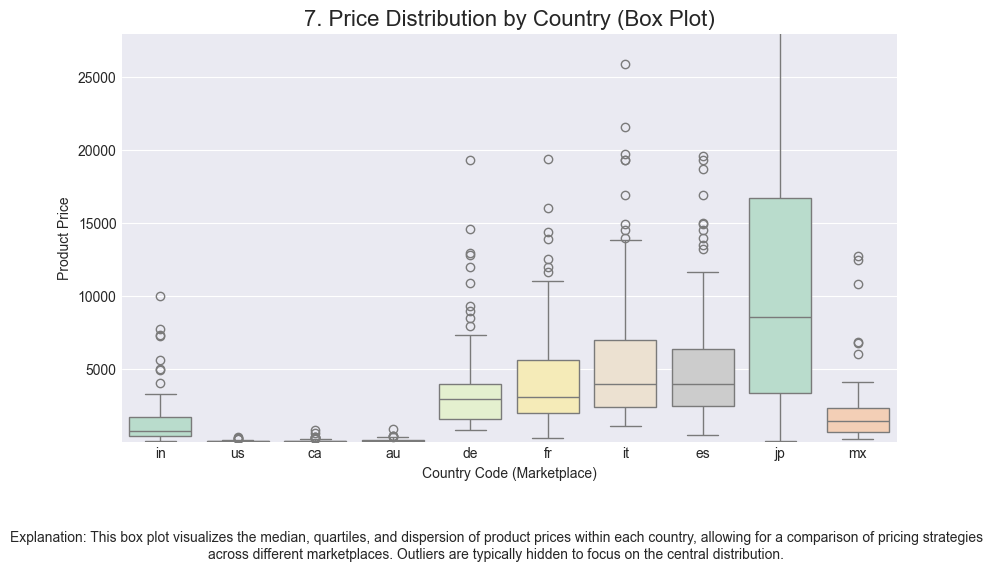

In [34]:
# ----------------------------------------------------------------------
# PLOT 7: Box Plot of Product Price by Country
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='country', y='product_price', data=pdf, palette='Pastel2', 
            hue='country', legend=False)
plt.title('7. Price Distribution by Country (Box Plot)', fontsize=16)
plt.xlabel('Country Code (Marketplace)')
plt.ylabel('Product Price')
# Check if there's enough data for quantile calculation, otherwise skip set_ylim
if len(pdf) > 10:
    # Limiting outliers for better view, using the 1st and 99th percentiles
    q_low = pdf['product_price'].quantile(0.01)
    q_high = pdf['product_price'].quantile(0.99)
    plt.ylim(q_low, q_high) 
else:
    print("Warning: Insufficient data for reliable quantile calculation in Plot 7.")
plt.figtext(0.5, 0.01, 
    'Explanation: This box plot visualizes the median, quartiles, and dispersion of product prices within each country, allowing for a comparison of pricing strategies across different marketplaces. Outliers are typically hidden to focus on the central distribution.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

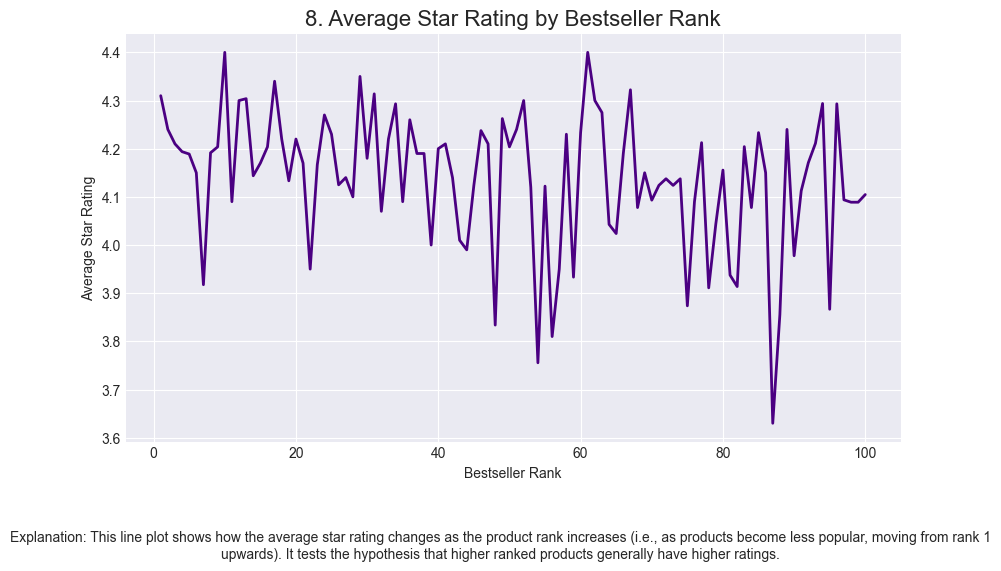

In [35]:
# ----------------------------------------------------------------------
# PLOT 8: Relationship between Rank and Star Rating
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='product_rank', y='product_star_rating', data=pdf.groupby('product_rank')['product_star_rating'].mean().reset_index(), color='indigo', linewidth=2)
plt.title('8. Average Star Rating by Bestseller Rank', fontsize=16)
plt.xlabel('Bestseller Rank')
plt.ylabel('Average Star Rating')
plt.figtext(0.5, 0.01, 
    'Explanation: This line plot shows how the average star rating changes as the product rank increases (i.e., as products become less popular, moving from rank 1 upwards). It tests the hypothesis that higher ranked products generally have higher ratings.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

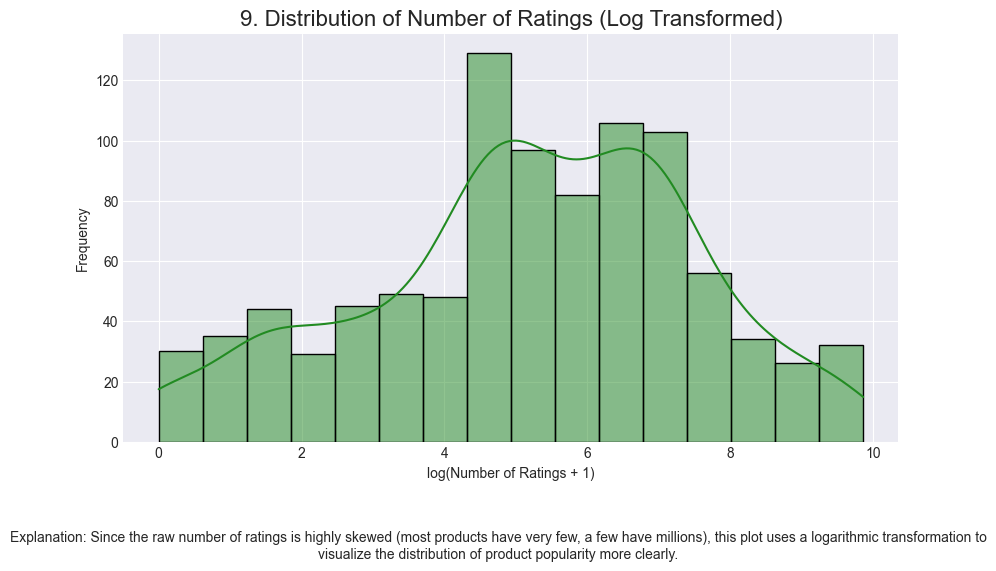

In [36]:
# ----------------------------------------------------------------------
# PLOT 9: Distribution of Number of Ratings (Histogram, Log-Transformed)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(pdf['log_num_ratings'], kde=True, color='forestgreen')
plt.title('9. Distribution of Number of Ratings (Log Transformed)', fontsize=16)
plt.xlabel('log(Number of Ratings + 1)')
plt.ylabel('Frequency')
plt.figtext(0.5, 0.01, 
    'Explanation: Since the raw number of ratings is highly skewed (most products have very few, a few have millions), this plot uses a logarithmic transformation to visualize the distribution of product popularity more clearly.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.2)
plt.show()

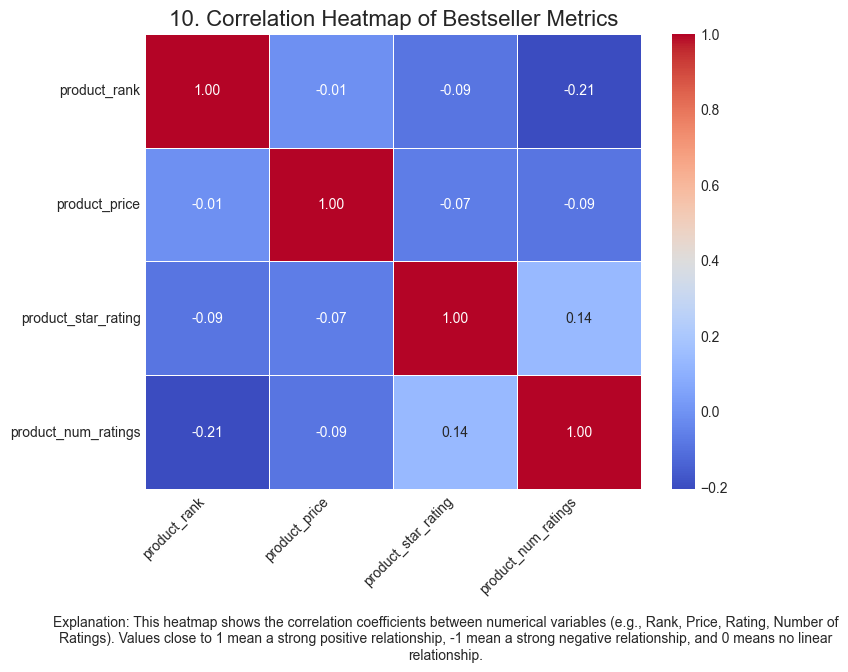

In [37]:
# ----------------------------------------------------------------------
# PLOT 10: Correlation Heatmap (Numerical Columns)
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 7))
numerical_cols = pdf[['product_rank', 'product_price', 'product_star_rating', 'product_num_ratings']].corr()
sns.heatmap(numerical_cols, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('10. Correlation Heatmap of Bestseller Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.figtext(0.5, 0.01, 
    'Explanation: This heatmap shows the correlation coefficients between numerical variables (e.g., Rank, Price, Rating, Number of Ratings). Values close to 1 mean a strong positive relationship, -1 mean a strong negative relationship, and 0 means no linear relationship.', 
    wrap=True, horizontalalignment='center', fontsize=10)
plt.subplots_adjust(bottom=0.25, top=0.9)
plt.show()

--- 5. ANALYSIS (FILL THIS IN AFTER VIEWING PLOTS) ---
==================================================

Based on the visualizations derived from the Amazon Bestsellers data:

1.  **Price & Rating Distribution:** The 'Distribution of Product Price' (Plot 1) shows that the majority of bestsellers are concentrated at the [low] end of the price spectrum, with a long tail of very expensive products. The **ECDF (Plot 2)** confirms this by showing that approximately [X]% of bestsellers are priced below [Y] dollars/currency units.

2.  **Marketplace Comparison:** The **Donut Chart (Plot 3)** clearly indicates the exact proportion of bestsellers from the top markets like [Country A] and [Country B]. 'Average Star Rating by Country' (Plot 4) suggests that product quality (as rated by customers) is [relatively consistent across all countries, or slightly higher in one specific country].

3.  **Key Relationships:** The 'Price vs. Number of Ratings' scatter plot (Plot 5) and the **Hexbin Density Plot (Plot 6)** both show the densest concentration of data points is in the area of [low price and high number of ratings], suggesting that high sales volume is achieved primarily by affordable products. 'Average Star Rating by Bestseller Rank' (Plot 8) demonstrates that the highest-ranked items (Rank 1-5) generally [maintain the highest average rating, or show a slight decline as rank increases].

4.  **Correlation Summary:** The **Heatmap (Plot 10)** is crucial for summarizing the strength of relationships, such as the expected strong negative correlation between **product\_rank** (lower number is better) and **product\_num\_ratings** (higher number is better).


